# Malenoma Skin Cancer Detection

### Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")

### Data Reading/Data Understanding
#### Defining the path for train and test images
**Here is the link for the dataset:---**

https://drive.google.com/drive/folders/1T9pdFSWBJa4w-o9MSjqwIJgHCcDT8Cc_?usp=sharing

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [8]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(r"C:\Users\ritik\Melanoma Skin Cancer Detection\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path(r"C:\Users\ritik\Melanoma Skin Cancer Detection\Skin cancer ISIC The International Skin Imaging Collaboration\Test")

In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [12]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [14]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writing the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [15]:
# Loading the validation data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [16]:
# Loading the testing data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [17]:
# List out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Data Visualization
#### Creating a code to visualize one instance of all the nine classes present in the dataset

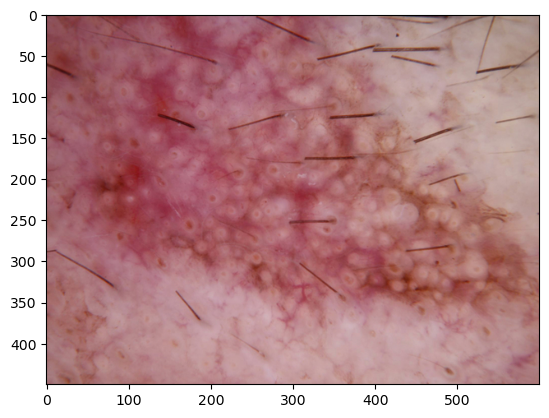

In [19]:
image = plt.imread((list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0]))
plt.imshow(image)

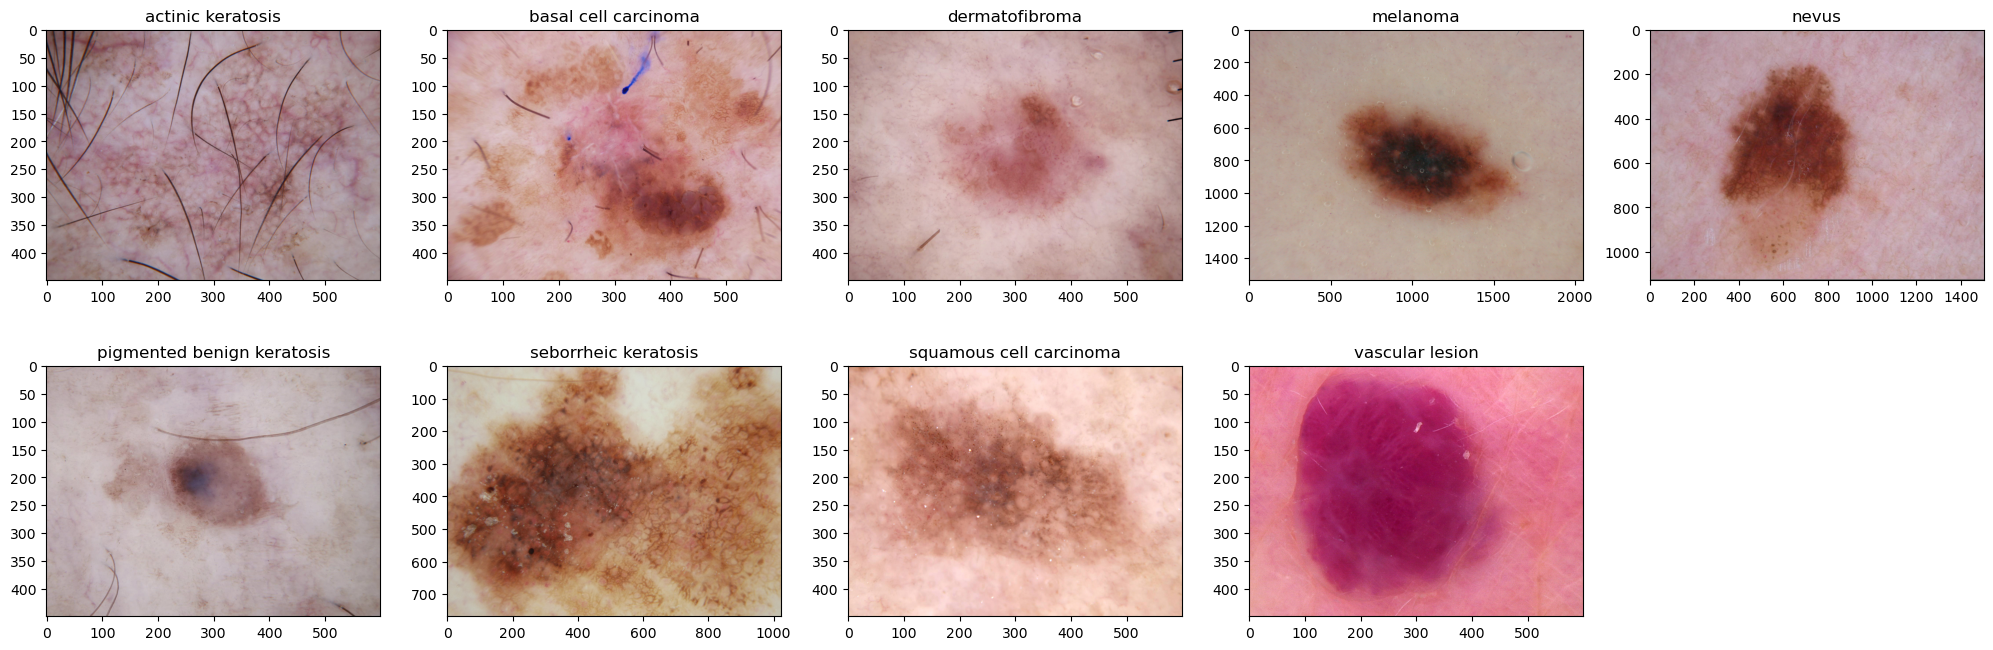

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [21]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.\
# `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [22]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### Model Building & training :

+ Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).

+ Choosing an appropriate optimiser and loss function for model training

+ Training the model for ~20 epochs

+ Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [24]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

#### Compile the model

In [26]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

#### Train the model

In [28]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.1887 - loss: 5.4464 - val_accuracy: 0.3177 - val_loss: 1.8343
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.3802 - loss: 1.7000 - val_accuracy: 0.4989 - val_loss: 1.4755
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.5154 - loss: 1.4143 - val_accuracy: 0.5436 - val_loss: 1.3767
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.5522 - loss: 1.2937 - val_accuracy: 0.5459 - val_loss: 1.3832
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.5872 - loss: 1.1451 - val_accuracy: 0.5257 - val_loss: 1.4597
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.6276 - loss: 1.0547 - val_accuracy: 0.5570 - val_loss: 1.3694
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6521 - loss: 0.9657 - val_accuracy: 0.5481 - val_loss: 1.4512
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7289 - loss: 0.7667 - val_accuracy: 0.5101 - val_loss:

### Visualizing training results

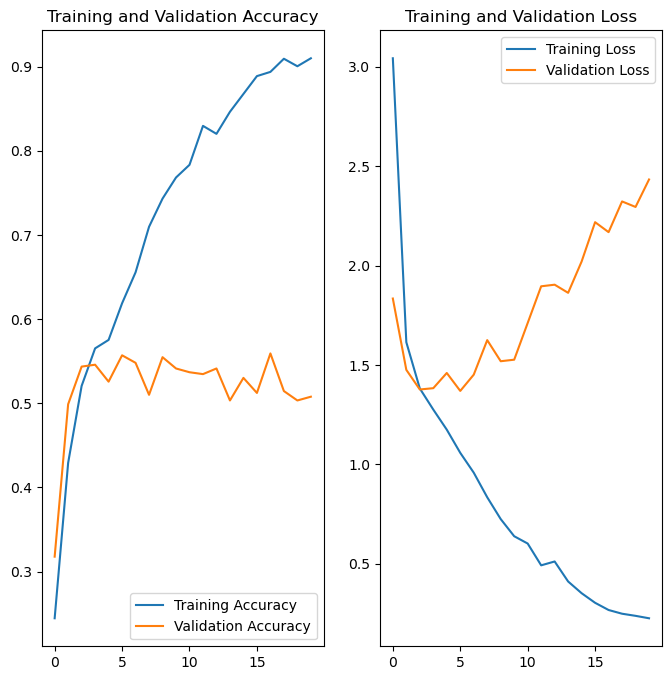

In [30]:
plot_cnn_metrics(history,epochs)

##### As the training accuracy increases over time, where as the validation accuracy stall at 50% accuracy in training process.

##### As the training loss dereases with epochs the validation loss increases.

##### Training accuracy and validation accuracy are off by large margins, and the model has achieved around 50% accuracy on the validation set.

##### The difference in accuracy between training and validation accuracy is noticeable which is a sign of overfitting.

### Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [33]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

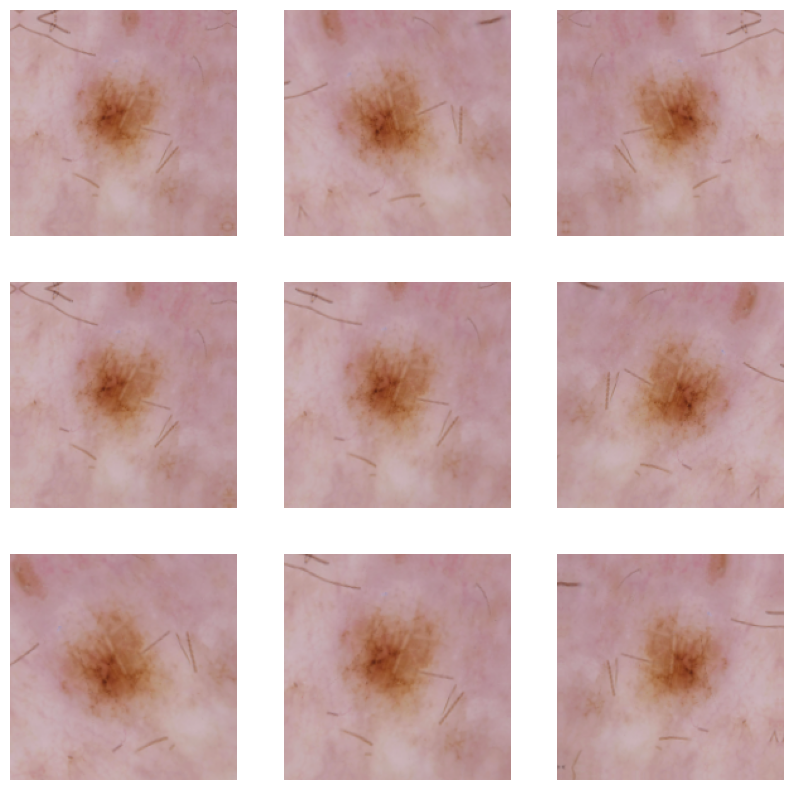

In [34]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Model Building & training on the augmented data :

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.


In [36]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))



### Compiling the model

In [38]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [40]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.2207 - loss: 6.3933 - val_accuracy: 0.2192 - val_loss: 1.8555
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.3368 - loss: 1.7944 - val_accuracy: 0.4720 - val_loss: 1.6047
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.4409 - loss: 1.6022 - val_accuracy: 0.5056 - val_loss: 1.4583
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.4703 - loss: 1.4533 - val_accuracy: 0.5145 - val_loss: 1.4330
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.5224 - loss: 1.3756 - val_accuracy: 0.4966 - val_loss: 1.4437
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.5166 - loss: 1.3544 - val_accuracy: 0.5324 - val_loss: 1.3479
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.5522 - loss: 1.2348 - val_accuracy: 0.5213 - val_loss: 1.3819
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.5270 - loss: 1.3227 - val_accuracy: 0.5436 - val_loss:

### Visualizing the results

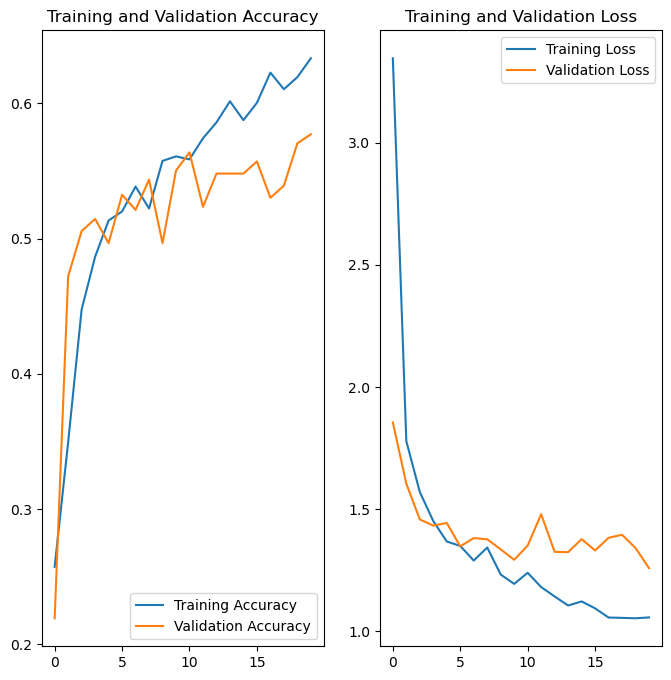

In [42]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.
As the training loss decreases with epochs the validation loss decreases and stalls.

The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around accuracy on the validation set.

The difference in accuracy between training and validation accuracy is still slightly noticeable which is a sign of overfitting.

### Model Building & training on the augmented data with dropout :

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [45]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [46]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.1930 - loss: 7.1102 - val_accuracy: 0.3289 - val_loss: 1.8843
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.3602 - loss: 1.7866 - val_accuracy: 0.4273 - val_loss: 1.6846
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.3910 - loss: 1.6379 - val_accuracy: 0.4966 - val_loss: 1.5427
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.4556 - loss: 1.5450 - val_accuracy: 0.4855 - val_loss: 1.5048
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.4976 - loss: 1.4382 - val_accuracy: 0.5056 - val_loss: 1.4294
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.4811 - loss: 1.4484 - val_accuracy: 0.5235 - val_loss: 1.4357
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.4930 - loss: 1.4285 - val_accuracy: 0.5168 - val_loss: 1.4251
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.5048 - loss: 1.3834 - val_accuracy: 0.5168 - val_loss:

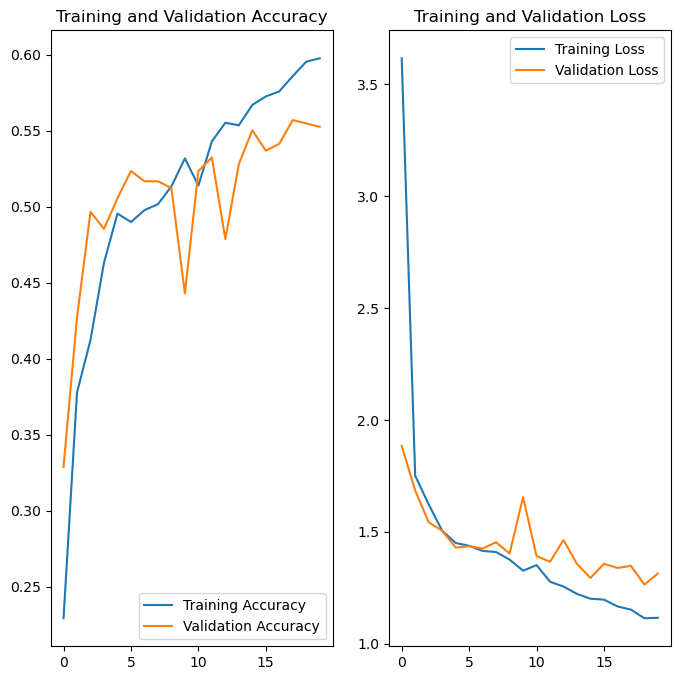

In [48]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.

As the training loss decreases with epochs the validation loss decreases

The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around accuracy on the validation set.

The difference in accuracy between training and validation accuracy is <b>very less

### **We can clearly see that the overfitting of the model has redused significantly when compared the earlier models**

### Class distribution:

Examining the current class distribution in the training dataset

Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.

Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [52]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


* seborrheic keratosis with 77 samples has the least number of samples

* pigmented benign keratosis with 462 samples dominate the data in terms proportionate number of samples

### Handling class imbalances:

Rectifing class imbalances present in the training dataset with Augmentor library.

In [69]:
!pip install Augmentor

In [73]:
import Augmentor
path_to_training_dataset = r"C:\Users\ritik\Melanoma Skin Cancer Detection\Skin cancer ISIC The International Skin Imaging Collaboration\Train"
data_dir_train = pathlib.Path(path_to_training_dataset)
data_dir_test = pathlib.Path(r"C:\Users\ritik\Melanoma Skin Cancer Detection\Skin cancer ISIC The International Skin Imaging Collaboration\Test")

for class_name in class_names:
    class_dir = os.path.join(path_to_training_dataset, class_name)

    if os.path.exists(class_dir):
        # Initialize Augmentor pipeline
        p = Augmentor.Pipeline(source_directory=class_dir, output_directory=r"C:\Users\ritik\Melanoma Skin Cancer Detection\Output_dir\New_train" + class_name + "/")
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(500)  # Generate 500 augmented samples
    else:
        print(f"Directory for class '{class_name}' not found.")

Initialised with 114 image(s) found.
Output directory set to C:\Users\ritik\Melanoma Skin Cancer Detection\Output_dir\New_trainactinic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1344974C590>: 100%|█| 500/500 [00:02<00:00, 173.86 Samples


Initialised with 376 image(s) found.
Output directory set to C:\Users\ritik\Melanoma Skin Cancer Detection\Output_dir\New_trainbasal cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1344C438850>: 100%|█| 500/500 [00:02<00:00, 168.53 Samples


Initialised with 95 image(s) found.
Output directory set to C:\Users\ritik\Melanoma Skin Cancer Detection\Output_dir\New_traindermatofibroma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x13263F6F250>: 100%|█| 500/500 [00:02<00:00, 174.35 Samples


Initialised with 438 image(s) found.
Output directory set to C:\Users\ritik\Melanoma Skin Cancer Detection\Output_dir\New_trainmelanoma/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1344C8D9490>: 100%|█| 500/500 [00:12<00


Initialised with 357 image(s) found.
Output directory set to C:\Users\ritik\Melanoma Skin Cancer Detection\Output_dir\New_trainnevus/.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x132711B0A50>: 100%|█| 500/500 [00:12<00:00, 39.79 Samples/


Initialised with 462 image(s) found.
Output directory set to C:\Users\ritik\Melanoma Skin Cancer Detection\Output_dir\New_trainpigmented benign keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1327312E190>: 100%|█| 500/500 [00:03<00:00, 164.15 Samples


Initialised with 77 image(s) found.
Output directory set to C:\Users\ritik\Melanoma Skin Cancer Detection\Output_dir\New_trainseborrheic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1344C42D9D0>: 100%|█| 500/500 [00:06<00:00, 73.07 Samples


Initialised with 181 image(s) found.
Output directory set to C:\Users\ritik\Melanoma Skin Cancer Detection\Output_dir\New_trainsquamous cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1344EB30750>: 100%|█| 500/500 [00:02<00:00, 170.86 Samples


Initialised with 139 image(s) found.
Output directory set to C:\Users\ritik\Melanoma Skin Cancer Detection\Output_dir\New_trainvascular lesion/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1344BEFB210>: 100%|█| 500/500 [00:02<00:


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types..

Lets take a look at total count of augmented images.

In [75]:
import pathlib

data_dir_train = pathlib.Path(r"C:\Users\ritik\Melanoma Skin Cancer Detection\Output_dir")
image_count_train = len(list(data_dir_train.glob('**/*.jpg')))
print(image_count_train)

4500


#### Let's see the distribution of augmented data after adding new images to the original training data.

#### Lets see the distribution of augmented data after adding new images to the original training data.

In [77]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [79]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

In [81]:
df['Label'].value_counts()

Label
New_trainactinic keratosis             500
New_trainbasal cell carcinoma          500
New_traindermatofibroma                500
New_trainmelanoma                      500
New_trainnevus                         500
New_trainpigmented benign keratosis    500
New_trainseborrheic keratosis          500
New_trainsquamous cell carcinoma       500
New_trainvascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [83]:
# initializing the parameter to load the images
batch_size = 32
img_height = 180
img_width = 180

In [85]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [87]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


In [106]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [108]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

In [110]:
df['Label'].value_counts()

Label
New_trainactinic keratosis             500
New_trainbasal cell carcinoma          500
New_traindermatofibroma                500
New_trainmelanoma                      500
New_trainnevus                         500
New_trainpigmented benign keratosis    500
New_trainseborrheic keratosis          500
New_trainsquamous cell carcinoma       500
New_trainvascular lesion               500
Name: count, dtype: int64

##### So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [100]:
# initializing the parameter to load the images
batch_size = 32
img_height = 180
img_width = 180

In [102]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [104]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


# Model Building & training on the rectified class imbalance data :

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~30 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [90]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [92]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
# Training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.1763 - loss: 4.3685 - val_accuracy: 0.3522 - val_loss: 1.6799
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.3480 - loss: 1.6839 - val_accuracy: 0.4222 - val_loss: 1.4814
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.4069 - loss: 1.5012 - val_accuracy: 0.3889 - val_loss: 1.6505
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.4203 - loss: 1.5172 - val_accuracy: 0.4678 - val_loss: 1.3177
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.4934 - loss: 1.3247 - val_accuracy: 0.4433 - val_loss: 1.4629
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.4947 - loss: 1.3187 - val_accuracy: 0.5222 - val_loss: 1.2338
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.5237 - loss: 1.2660 - val_accuracy: 0.5278 - val_loss: 1.2430
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.5376 - loss: 1.2231 - val_accu

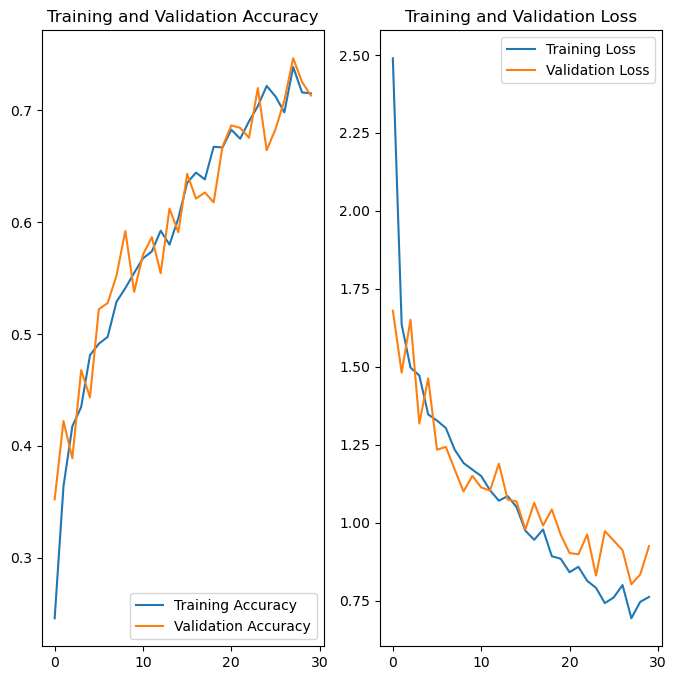

In [96]:
# Visualizing model results
plot_cnn_metrics(history,epochs)

As the training accuracy increases linearly over time, where as the validation accuracy increases in training process.

As the training loss decreases with epochs the validation loss also decreases.

The plots show that gap between training accuracy and validation accuracy have decreased significantly from previous model, and it has achieved around 70% accuracy on the validation set.

The difference in accuracy between training and validation accuracy is also less.


Improved the accuracy from 55% to 70%.
